<a href="https://colab.research.google.com/github/Kavyapriyakp/Environmental-Hydrology-for-Data-Science/blob/main/Classification_of_AQI_Levels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Prepared by: RA1811029010034

In [50]:
# install awesomeness
!pip install pywaffle
!pip install bubbly

In [51]:
import os
import pandas as pd
import numpy as np
from itertools import islice

# import viz libraries here
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from pywaffle import Waffle
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode, iplot
from bubbly.bubbly import bubbleplot

# Disable warnings 
import warnings
warnings.filterwarnings('ignore')

# for slide deck embed
from IPython.display import HTML

In [52]:
# Global Functions and Utility functions

COLOR_ASSOCIATION = {
    '#00b050': 'Good',
    '#91cf4f': 'Satisfactory',
    '#fefe00': 'Moderate',
    '#ffbf00': 'Poor',
    '#fe0000': 'Very Poor',
    '#bf0000': 'Severe',
    '#737373': 'Not Available'
}

def trim(x):
    """Strip of trailing whitespace"""
    
    return x.strip()

def order_bucket(old, order=['Good', 'Satisfactory', 'Moderate', 'Poor', 'Very Poor', 'Severe', 'Not Available']):
    """Order by bucket
    `old` => Old dictionary
    `order` => Order of AQI buckets (optional)
    """
    
    new = {}
    for cat in order:
        try:
            new[cat] = old[cat]
        except:
            continue
    return new

In [53]:
# Loading the data


try:
    cd = pd.read_csv("/content/city_day.csv")
    ch = pd.read_csv("/content/city_hour.csv")
    sd = pd.read_csv("/content/station_day.csv")
    sh = pd.read_csv("/content/station_hour.csv")
    st = pd.read_csv("/content/stations.csv")
    city = pd.read_csv("/content/cities_r2.csv")
    city_co = pd.read_csv("/content/Indian_cities.csv")
    
except:
    print("File na!")

In [54]:
# prepare data on cities

city['name_of_city'] = city['name_of_city'].apply(trim)
new_names = {
    'Ahmadabad': 'Ahmedabad',
    'Amravati': 'Amaravati',
    'Gurgaon': 'Gurugram',
    'Greater Mumbai': 'Mumbai',
    'Greater Hyderabad': 'Hyderabad',
}
city['name_of_city'] = city['name_of_city'].replace(new_names)

rel_cols = [
    'name_of_city',
    'state_name',
    'population_total',
    'population_male',
    'population_female',
    '0-6_population_total',
    'literates_total',
    'literates_male',
    'literates_female',
    'sex_ratio',
    'effective_literacy_rate_total',
    'total_graduates',
]
city = city[rel_cols]

cities = ['Ahmedabad',
 'Aizawl',
 'Amaravati',
 'Amritsar',
 'Bengaluru',
 'Bhopal',
 'Brajrajnagar',
 'Chandigarh',
 'Chennai',
 'Coimbatore',
 'Delhi',
 'Ernakulam',
 'Gurugram',
 'Guwahati',
 'Hyderabad',
 'Jaipur',
 'Jorapokhar',
 'Kochi',
 'Kolkata',
 'Lucknow',
 'Mumbai',
 'Patna',
 'Shillong',
 'Talcher',
 'Thiruvananthapuram',
 'Visakhapatnam']
city_t = city[city['name_of_city'].isin(cities)]

# combine data into `df`
df = pd.merge(
    left=cd,
    right=city_t,
    left_on='City',
    right_on='name_of_city',
    how='outer'
)

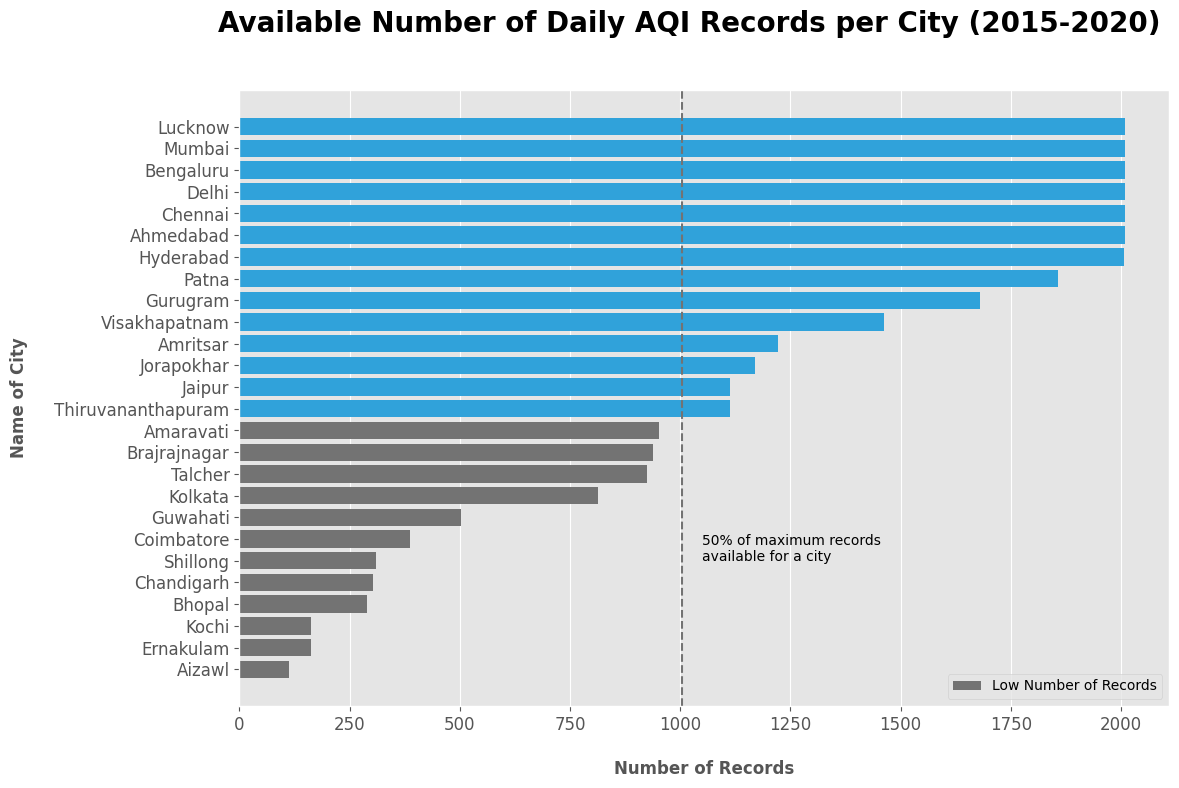

In [55]:
# setting matplotlib parameters
plt.rcParams['figure.figsize'] = 12, 8
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.labelsize'] = 15
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['figure.titlesize'] = 20
plt.rcParams['figure.titleweight'] = 'bold'
plt.rcParams['axes.titlelocation'] = 'left'
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['legend.shadow'] = False
plt.rcParams['legend.frameon'] = True

# plotting num records per city
temp = pd.DataFrame(cd['City'].value_counts()).sort_values(by='City', ascending=True).to_dict()['City']
with plt.style.context('ggplot'):
    fig, ax = plt.subplots()
    ax.axvline(x=1005, c='#737373', linestyle='--')
    ax.barh(list(temp.keys()), list(temp.values()), label='Low Number of Records', color=['#737373']*12 + ['#30a2da']*14)
    ax.legend()
    ax.yaxis.grid(False)
    ax.text(x=1050, y='Shillong', s='50% of maximum records\navailable for a city')
    ax.set_xlabel("\nNumber of Records")
    ax.set_ylabel("Name of City\n")
    fig.suptitle("Available Number of Daily AQI Records per City (2015-2020)")
    #ax.set_title("Available number of daily AQI records per city (2015-2020)")

💡 **INSIGHTS**
- The most records a city in the given dataset has is 2009
- 12 out of the 26 cities have total day-wise records for 2015-2020 which is lesser than the maximum number of records available for a city i.e 2009 for Mumbai, Delhi, Lucknow, Chennai, Bengaluru, Ahmedabad, Hyderabad
- I have considered a 50% threshold of 2009 to divide the cities into WMR and WLR
    - WMR: With More Records (In blue)
    - WLR: With Less Records (In grey)
- Why do the WLR states have low records?
    - Hypothesis 1: Maybe they don't have the resources
    - Hypothesis 2: Maybe they are not prioritized by AQI
- Cities with low records may or may not be crossed out for investment on the basis of whether
    - They have low records because they are clean and safe
    - They have low records because they are not efficiently monitored

In [56]:
# wmr will mean they have enough records to compare
# wlr means these places need to be provided more records if the pollution levels are getting worse here
# btw, the govt. does prioritise areas when they need to make a comparison

# cities with more than 1005 records
CITIES_WMR = ['Thiruvananthapuram',
 'Jaipur',
 'Jorapokhar',
 'Amritsar',
 'Visakhapatnam',
 'Gurugram',
 'Patna',
 'Hyderabad',
 'Lucknow',
 'Bengaluru',
 'Mumbai',
 'Chennai',
 'Delhi',
 'Ahmedabad'] 

# cities with less than 1005 records
CITIES_WLR = ['Aizawl',
 'Ernakulam',
 'Kochi',
 'Bhopal',
 'Chandigarh',
 'Shillong',
 'Coimbatore',
 'Guwahati',
 'Kolkata',
 'Talcher',
 'Brajrajnagar',
 'Amaravati']

In [57]:
# custom aggregate functions

def unique_cnt(series):
    """Returns count of unique values in a series"""
    
    return len(series.unique())

def active_station_cnt(series):
    """Returns count of active stations"""
    
    return (list(series).count('Active'))

def asset_plot(df, xlabel, title):
    """ Plot a bar plot of quantity of a particular asset to a city
    > Ensure that the `df` follows a structure as follows
    | City | StationId |
    
    """
    
    # preapre data for wmr and wlr
    wmr = df[df['City'].isin(CITIES_WMR)]
    wlr = df[df['City'].isin(CITIES_WLR)]
    
    
    # set to default values
    mpl.rc_file_defaults()
    plt.rcParams['figure.figsize'] = 10, 8
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['font.serif'] = 'Ubuntu'
    plt.rcParams['font.monospace'] = 'Ubuntu Mono'
    plt.rcParams['axes.labelweight'] = 'bold'
    plt.rcParams['axes.labelsize'] = 15
    plt.rcParams['xtick.labelsize'] = 12
    plt.rcParams['ytick.labelsize'] = 12
    plt.rcParams['axes.titlesize'] = 15
    plt.rcParams['figure.titlesize'] = 20
    plt.rcParams['figure.titleweight'] = 'bold'
    plt.rcParams['axes.titlelocation'] = 'left'
    plt.rcParams['axes.titleweight'] = 'normal'
    with plt.style.context('ggplot'):
        fig, axs = plt.subplots(nrows=2, ncols=1, sharex=True)
        axs[0].barh(list(wmr['City']), list(wmr['StationId']), color='#30a2da')
        axs[1].barh(list(wlr['City']), list(wlr['StationId']), color='#30a2da')
        #ax.yaxis.grid(False)
        #ax.xaxis.grid(False)
        
        #axs[0].set_xlabel(f"\n{xlabel}")
        axs[0].set_title(f"Cities with more records")
        #axs[0].set_ylabel("Name of City\n")
        #axs[1].set_xlabel(f"\n{xlabel}")
        axs[1].set_title(f"Cities with less records")
        fig.text(0.5, 0.04, 'Number of Stations', ha='center', fontsize=12)
        fig.suptitle(f"{title} (2015-2020)")
    

In [58]:
# prep data for 3-class categorization

temp_wmr = temp_wmr.reset_index()
temp_wmr['Acceptable'] = temp_wmr['Good'] + temp_wmr['Satisfactory']
temp_wmr['Unacceptable'] = temp_wmr['Moderate'] + temp_wmr['Poor'] + temp_wmr['Very Poor'] + temp_wmr['Severe']
temp_wmr.sort_values(by='Unacceptable', ascending=False)

temp_wlr = temp_wlr.reset_index()
temp_wlr['Acceptable'] = temp_wlr['Good'] + temp_wlr['Satisfactory']
temp_wlr['Unacceptable'] = temp_wlr['Moderate'] + temp_wlr['Poor'] + temp_wlr['Very Poor'] + temp_wlr['Severe']
temp_wlr.sort_values(by='Unacceptable', ascending=False)

AQI_Bucket,index,City,Good,Satisfactory,Moderate,Poor,Very Poor,Severe,Not Available,Acceptable,Unacceptable
2,2,Bhopal,1.0,26.0,57.0,11.0,1.0,0.0,4.0,27.0,69.0
3,3,Brajrajnagar,1.0,13.0,45.0,13.0,4.0,0.0,24.0,14.0,62.0
11,11,Talcher,2.0,16.0,35.0,9.0,10.0,3.0,25.0,18.0,57.0
7,7,Guwahati,23.0,27.0,22.0,14.0,12.0,1.0,1.0,50.0,49.0
8,8,Kochi,0.0,51.0,46.0,1.0,0.0,0.0,2.0,51.0,47.0
9,9,Kolkata,20.0,30.0,23.0,13.0,8.0,1.0,5.0,50.0,45.0
4,4,Chandigarh,16.0,51.0,24.0,7.0,1.0,0.0,2.0,67.0,32.0
6,6,Ernakulam,0.0,64.0,30.0,0.0,0.0,0.0,6.0,64.0,30.0
1,1,Amaravati,17.0,43.0,23.0,5.0,1.0,0.0,12.0,60.0,29.0
5,5,Coimbatore,11.0,75.0,3.0,0.0,0.0,0.0,11.0,86.0,3.0


In [59]:
# move this func on top later
def three_cat_comp(df1, df2):
    """ Interactive comparison across 3 categories """

    fig = go.Figure()
    fig = make_subplots(rows=2, cols=1, 
                       subplot_titles=('Cities with more records', 'Cities with less records'))
    fig.add_trace(go.Bar(
        x=df1['City'],
        y=df1['Acceptable'],
        name='Acceptable levels',
        marker_color='#00b050',
    ), row=1, col=1)

    fig.add_trace(go.Bar(
        x=df1['City'],
        y=df1['Unacceptable'],
        name='Unacceptable levels',
        marker_color='#bf0000',
    ), row=1, col=1)

    fig.add_trace(go.Bar(
        x=df1['City'],
        y=df1['Not Available'],
        name='Missing Records',
        marker_color='#737373',
    ), row=1, col=1)
    
    fig.add_trace(go.Bar(
        x=df2['City'],
        y=df2['Acceptable'],
        marker_color='#00b050',
        showlegend=False,
    ), row=2, col=1)

    fig.add_trace(go.Bar(
        x=df2['City'],
        y=df2['Unacceptable'],
        marker_color='#bf0000',
        showlegend=False,
    ), row=2, col=1)

    fig.add_trace(go.Bar(
        x=df2['City'],
        y=df2['Not Available'],
        marker_color='#737373',
        showlegend=False,
    ), row=2, col=1)

    fig.update_layout(template='ggplot2', barmode='group', xaxis_tickangle=-45, title_text='Percentages of AQI Levels per City (2015-2020)',
                     height=700, width=1000)
    
    return fig.show()

# call the function
three_cat_comp(temp_wmr, temp_wlr)

In the above visualization, I introduce a new way of classifying the AQI levels in order to simplify viz:
- If the AQI bucket is Good or Satisfactory, it's put into the **Acceptable** label => Means it does not harm people too much
- If the AQI bucket is Moderate, Poor, Very Poor or Severe, it's put into the **Unacceptable** label => Means it can cause harm to a healthy population
- **Missing** is a new label that takes into account the missing or null values of AQI buckets => Missing data is a red flag as it indicates poor administration or faulty apparatus


💡 **INSIGHTS**

- Over the last 5 years, Ahmedabad has had the lowest amount of Acceptable levels, 3rd highest amount of Unacceptable levels and the highest amount in terms of Missing levels in all WMR cities
    - Other cities that look troubled are Delhi, Gurugram, Patna, Lucknow, Jaipur and Jorapokhar
- Thiruvananthapuram is a happy outlier in that top bar plot
- Amongst the WLR cities, Bhopal looks the most troubled
    - Other cities in WLR that have recorded more Unacceptable days than Acceptable ones are Brajrajnagar and Talcher

<div class="h3">Which cities are under the radar as of now?</div>

With the analysis so far, a few cities have emerged as potential recipients of the monetary funding to improve their state. These are =>
- Ahmedabad: A very high percentage of the days it has registered measurements show unacceptable AQI levels
- Delhi: Same as Ahmedabad. Also, it's highly discussed in national and international media
- Kolkata: *The more stations, but less number of records* phenomenon puts Kolkata under scrutiny for poor administration
- Other cities that make it to this list are 
    - Gurugram
    - Patna
    - Lucknow
    - Jaipur
    - Jorapokhar
    - Bhopal
    - Brajrajnagar
    - Talcher

<div class="h3">Using a State Transition Idea to Prioritize Cities based on Air Pollution Levels</div>

From above, we have 11 cities that make it into the list of cities we need to consider for monetary investment. What we need next is a way to filter these cities into 3 main cities. In this section, I discuss one approach: Modelling the Pollution in a City as a State(or Level) Transition diagram.

In [60]:
cd['AQI_Bucket'] = cd['AQI_Bucket'].fillna('Not Available')

def to_level(x):
    """Converting to a level"""
    
    if(x in ['Good', 'Satisfactory']):
        return 'Level 1'
    elif(x in ['Moderate', 'Poor']):
        return 'Level 2'
    elif(x in ['Very Poor', 'Severe']):
        return 'Level 3'
    elif(x == 'Not Available'):
        return 'Level 4'

def window(seq, n=2):
    '''Source: https://stackoverflow.com/questions/47297585/building-a-transition-matrix-using-words-in-python-numpy'''
    """Sliding window width n from seq.  From old itertools recipes."""
    
    it = iter(seq)
    result = tuple(islice(it, n))
    if len(result) == n:
        yield result
    for elem in it:
        result = result[1:] + (elem,)
        yield result
        
def make_trans_mat(states):
    """Make transition probability matrix"""
    
    # get the counts
    pairs = pd.DataFrame(window(states), columns=['Current', 'Next'])
    c = pairs.groupby('Current', as_index=False).agg({'Next': 'count'})
    c.columns = ['Current', 'Total']
    k = pd.DataFrame(pairs.groupby('Current')['Next'].value_counts())
    k.columns = ['Count']
    k = k.reset_index()
    
    # calculate probabilities
    t_mat = pd.merge(k, c)
    t_mat['Prob'] = t_mat['Count'] / t_mat['Total']
    t_mat = t_mat.pivot(index='Current', columns='Next', values='Prob').fillna(0)
    
    return t_mat

def model_city(city):
    """Build the model for a city"""
    
    # define states
    t_city = cd[cd['City']==city]
    t_city['Level'] = t_city['AQI_Bucket'].apply(to_level)
    
    # make_trans_mat
    possible_states = list(t_city['Level'])
    return make_trans_mat(possible_states)

def agg_models(cities):
    """Aggregate models"""
    
    # prep data
    i = 0
    c_name = cities[i]
    temp = model_city(cities[i])
    temp['City'] = c_name
    for i in range(1, len(cities)):
        city_df = model_city(cities[i])
        city_df['City'] = cities[i]
        temp = pd.concat([temp, city_df])
        
    # rename
    temp = temp[['Level 1', 'Level 2', 'Level 3', 'City']]
    temp = temp.fillna(0)
    return temp

def plot_probs(city_list, level_no, mode='imp'):
    """
    Plot probs for `cities` to transition into `level no`
    from any other level
    """
    
    nxt = f'Level {level_no}'
    
    # aggregate data
    e = agg_models(city_list).sort_values(by=nxt, ascending=False).reset_index()
    e = e[(e['Current']!=nxt) & (e['Current']!='Level 4')][['Current', nxt, 'City']]

    # overlook very small probabilities
    e[nxt] = round(e[nxt], 2)
    e = e[e[nxt]>0.0]
    
    # create the dataframes
    improvements = e[e['Current']>nxt].reset_index(drop=True)
    deteriorations = e[e['Current']<nxt].reset_index(drop=True)
    
    if(mode=='imp'):
        return improvements.style.set_caption(f'Improvements to Level {level_no}')\
            .background_gradient(cmap='inferno')
    elif(mode=='det'):
        return deteriorations.style.set_caption(f'Deteriorations to Level {level_no}')\
            .background_gradient(cmap='inferno')

🔍 **METRICS CREATED**

For this section, two key metrics are used:
* `Unacceptable AQI Level Percentage`(UALP) = (`Number of Unacceptable AQI Levels` / `Number of Records`) * 100
* `Indeterminable AQI Level Percentage`(IALP) = (`Number of Indeterminable AQI Levels` / `Number of Records`) * 100

`Record` => A record is registered when there is an entry for a given day in the dataset. A record for a given day does not indicate that the day has a determinable AQI level.


Ideally, a city that is high priority on the AQI index will have a high UALP. Having a high IALP indicates problems with the data collection of the city.

In [61]:
# convert to datetime
cd['Date'] = pd.to_datetime(cd['Date'])

# engineer into year, month
def ret_yr(x):
    
    return (x.strftime("%Y"))

def ret_mon(x):
    
    return (x.strftime("%B"))

cd['Year'] = cd['Date'].apply(ret_yr)
cd['Month'] = cd['Date'].apply(ret_mon)

# convert to BTX
cd['BTX'] = cd['Benzene'] + cd['Toluene'] + cd['Xylene']

In [62]:
def cnt_acc(series):
    
    return (list(series).count('Good') + (list(series).count('Satisfactory')))

def cnt_unacc(series):
    
    return (list(series).count('Moderate') + (list(series).count('Poor')) 
           + list(series).count('Very Poor') + list(series).count('Severe'))

def cnt_navail(series):
    
    return (list(series).count('Not Available'))

# feature engineer
cd_tot = cd.groupby(['City', 'Year'], as_index=False).agg({'Date':'count'})
cd_tot.columns = ['City', 'Year', 'Recorded']
cd_acc = cd.groupby(['City', 'Year'], as_index=False).agg({'AQI_Bucket':cnt_acc})
cd_acc.columns = ['City', 'Year', 'Acceptable']
cd_acc = cd_acc.drop(['City', 'Year'], axis=1)
cd_unacc = cd.groupby(['City', 'Year'], as_index=False).agg({'AQI_Bucket':cnt_unacc})
cd_unacc.columns = ['City', 'Year', 'Unacceptable']
cd_unacc = cd_unacc.drop(['City', 'Year'], axis=1)
cd_navail = cd.groupby(['City', 'Year'], as_index=False).agg({'AQI_Bucket':cnt_navail})
cd_navail.columns = ['City', 'Year', 'Not Available']
cd_navail = cd_navail.drop(['City', 'Year'], axis=1)

# filter it
yr_wise = pd.concat([cd_tot, cd_acc, cd_unacc, cd_navail], axis=1)
filtered = ['Ahmedabad', 'Patna', 'Delhi', 'Gurugram', 'Lucknow', 'Kolkata', 'Talcher', 'Guwahati']
yr_wise_f = yr_wise[yr_wise['City'].isin(filtered)]

# convert to percentages
yr_wise_f['Acceptable_Percent'] = round((yr_wise_f['Acceptable'] / yr_wise_f['Recorded']) * 100, 2)
yr_wise_f['Unacceptable_Percent'] = round((yr_wise_f['Unacceptable'] / yr_wise_f['Recorded']) * 100, 2)
yr_wise_f['Not_Available_Percent'] = round((yr_wise_f['Not Available'] / yr_wise_f['Recorded']) * 100, 2)

yr_wise_f['Year'] = yr_wise_f['Year'].astype('int')

In the visualization below, each subplot represents a year. The idea of the visualization is to show the transition of each of the 8 cities across the UALP and IALP measures for the last 6 years.

UALP is on the X Axis and IALP is on the Y Axis.

In [63]:
fig = make_subplots(rows=3, cols=2, subplot_titles=['2015', '2016', '2017', '2018', '2019', '2020'])

# add traces
year = yr_wise_f[yr_wise_f['Year']==2015]
fig.add_trace(
    go.Scatter(x=year['Unacceptable_Percent'],
              y=year['Not_Available_Percent'],
              mode='markers',
              text=year['City'],
              marker = dict(
                  size=15,
                  color = ['rgb(127,60,141)', 'rgb(17,165,121)', 'rgb(57,105,172)', 'rgb(128,186,90)', 'rgb(230,131,16)'],
              ),
              opacity=0.8,
              showlegend=False),
    row=1, col=1)

year = yr_wise_f[yr_wise_f['Year']==2016]
fig.add_trace(
    go.Scatter(x=year['Unacceptable_Percent'],
              y=year['Not_Available_Percent'],
              mode='markers',
              text=year['City'],
              marker = dict(
                  size=15,
                  color = ['rgb(127,60,141)', 'rgb(17,165,121)', 'rgb(57,105,172)', 'rgb(128,186,90)', 'rgb(230,131,16)'],
              ),
              opacity=0.8,
              showlegend=False),
    row=1, col=2)

year = yr_wise_f[yr_wise_f['Year']==2017]
fig.add_trace(
    go.Scatter(x=year['Unacceptable_Percent'],
              y=year['Not_Available_Percent'],
              mode='markers',
              text=year['City'],
              marker = dict(
                  size=15,
                  color = ['rgb(127,60,141)', 'rgb(17,165,121)', 'rgb(57,105,172)', 'rgb(128,186,90)', 'rgb(230,131,16)', 'rgb(249,123,114)'],
              ),
              opacity=0.8,
              showlegend=False),
    row=2, col=1)

year = yr_wise_f[yr_wise_f['Year']==2018]
fig.add_trace(
    go.Scatter(x=year['Unacceptable_Percent'],
              y=year['Not_Available_Percent'],
              mode='markers',
              text=year['City'],
              marker = dict(
                  size=15,
                  color = ['rgb(127,60,141)', 'rgb(17,165,121)', 'rgb(57,105,172)', 'rgb(231,63,116)', 'rgb(128,186,90)', 'rgb(230,131,16)', 'rgb(249,123,114)'],
              ),
              opacity=0.8,
              showlegend=False),
    row=2, col=2)

year = yr_wise_f[yr_wise_f['Year']==2019]
fig.add_trace(
    go.Scatter(x=year['Unacceptable_Percent'],
              y=year['Not_Available_Percent'],
              mode='markers',
              text=year['City'],
              marker = dict(
                  size=15,
                  color = ['rgb(127,60,141)', 'rgb(17,165,121)', 'rgb(57,105,172)', 'rgb(242,183,1)', 'rgb(231,63,116)', 'rgb(128,186,90)', 'rgb(230,131,16)', 'rgb(249,123,114)'],
              ),
              opacity=0.8,
              showlegend=False),
    row=3, col=1)

year = yr_wise_f[yr_wise_f['Year']==2020]
fig.add_trace(
    go.Scatter(x=year['Unacceptable_Percent'],
              y=year['Not_Available_Percent'],
              mode='markers',
              text=year['City'],
              marker = dict(
                  size=15,
                  color = ['rgb(127,60,141)', 'rgb(17,165,121)', 'rgb(57,105,172)', 'rgb(242,183,1)', 'rgb(231,63,116)', 'rgb(128,186,90)', 'rgb(230,131,16)', 'rgb(249,123,114)'],
              ),
              opacity=0.8,
              showlegend=False),
    row=3, col=2)

# Update xaxis properties
fig.update_xaxes(title_text="Percentage of Unacceptable AQI Levels", row=1, col=1, range=[-10,110])
fig.update_xaxes(title_text="Percentage of Unacceptable AQI Levels", row=1, col=2, range=[-10,110])
fig.update_xaxes(title_text="Percentage of Unacceptable AQI Levels", row=2, col=1, range=[-10,110])
fig.update_xaxes(title_text="Percentage of Unacceptable AQI Levels", row=2, col=2, range=[-10,110])
fig.update_xaxes(title_text="Percentage of Unacceptable AQI Levels", row=3, col=1, range=[-10,110])
fig.update_xaxes(title_text="Percentage of Unacceptable AQI Levels", row=3, col=2, range=[-10,110])

# Update yaxis properties
fig.update_yaxes(title_text="Percentage of Indeterminable AQI Levels", row=1, col=1, range=[-20,110])
fig.update_yaxes(title_text="", row=1, col=2, range=[-20,110])
fig.update_yaxes(title_text="Percentage of Indeterminable AQI Levels", row=2, col=1, range=[-20,110])
fig.update_yaxes(title_text="", row=2, col=2, range=[-20,110])
fig.update_yaxes(title_text="Percentage of Indeterminable AQI Levels", row=3, col=1, range=[-20,110])
fig.update_yaxes(title_text="", row=3, col=2, range=[-20,110])

fig.update_layout(template='ggplot2',
    title={
        "text": "Unacceptable AQI Levels vs Missing AQI Levels",
        "font": {"family": "Rockwell", "size": 25},
        "xanchor": "center",
        "yanchor": "top",
    },
    width=900,
    height=1200,
)
fig.show()

💡 **INSIGHTS**

* As the years progress, a general trend sees the cities move towards the bottom right.
    * The bottom right is a region with high UALP and low IALP
    * This indicates that data collection has in general become better for these cities over the given time period
    * The year 2017 is an outlier in the sense that both Ahmedabad and Patna have shown a higher IALP measure than what they did have in 2016. Especially, Patna with a rise of about 50% from 2016 in the IALP. This however is restored to 1% in 2018. This does cast reasonable doubt.
* The following states are removed from this list of 8 states for the following reasons:
    * Talcher => It has a population of around 40,000 only which is way lesser than the other cities. So, a fair comparison is not possible
    * Guwahati => Data available only for 2019 and 2020
    * Kolkata => Data available for only 2018,2019 and 2020

**NOTE:** In an earlier statement, I had cast doubt on Kolkata's administration because of the lower number of records inspite of having more stations in place. This could be because Kolkata has only begun registering records since 2018(3 years lesser than the time for most other cities in this data)

The above visualization does provide insights. But, a more improve way of seeing a pattern would be using a bubble chart with only the 5 top cities (Ahmedabad, Delhi, Patna, Gurugram and Lucknow) in consideration.

In [81]:
import numpy as np
import matplotlib.pyplot as plt
import imageio
import matplotlib.animation as animation
# filter cities
filtered = ['Ahmedabad', 'Patna', 'Delhi', 'Gurugram', 'Lucknow', 'Kolkata', 'Talcher', 'Guwahati']
city_f = city[city['name_of_city'].isin(filtered)]
bubble = pd.merge(
    left=yr_wise_f,
    right=city_f,
    left_on='City',
    right_on='name_of_city',
)

# prep data for bubble plot
bubble = bubble[(bubble['City']!='Guwahati') & (bubble['City']!='Talcher') & (bubble['City']!='Kolkata')]
# area of each city in sq kms.
areas = pd.DataFrame({
    'City': ['Ahmedabad', 'Delhi', 'Gurugram', 'Lucknow', 'Patna'],
    'Area(km2)': [464, 1484, 732, 349, 136]
})
bubble = pd.merge(bubble, areas)
# per_capita_income
per_cap_inc = pd.DataFrame({
    'City': ['Ahmedabad', 'Delhi', 'Gurugram', 'Lucknow', 'Patna'],
    'Per_Capita_Income(INR)': [173000, 360644, 122000, 71000, 106000]
})
bubble = pd.merge(bubble, per_cap_inc)

fig = px.scatter(bubble, x="Unacceptable_Percent", y="Not_Available_Percent",animation_frame="Year", animation_group="City",
           color="City", hover_name="City", size='Area(km2)', size_max=65, color_discrete_sequence=px.colors.qualitative.G10)
fig.update_layout(template='ggplot2',
    title={
        "text": f"The Five Year Transition of AQI in our Top 5 Cities",
        "font": {"family": "Rockwell", "size": 25},
        "xanchor": "center",
        "yanchor": "top",
    },
    height=500,
    xaxis_title='Recorded Days with Unacceptable AQI Levels(%)',
    yaxis_title='Recorded Days with Indeterminable AQI Levels(%)',
)
fig.show()
